In [59]:
import numpy as np
from numba import njit
from numba.experimental import jitclass
from numba import int32, float32
import matplotlib.pyplot as plt

In [60]:
spec = [
    ('L', int32),
    ('mag', int32[:]),
    ('T', float32),
    ('j', int32)
]
rng = np.random.default_rng(seed=None)
@jitclass(spec)
class Ising:
    # mag: np.ndarray
    # L: int
    # T: float
    # j: int
    # @njit
    def __init__(self, L, T) -> None:
        # self.rng = np.random.default_rng(seed=None)
        self.mag = self.CreateMagnet(L)
        self.L = L
        self.T = T
        self.j = 1

    # @njit
    def CreateMagnet(self, L):
        mag = rng.choice([1, -1], (L, L), dtype=int32)
        
        return mag
    
    # @njit
    def takeStep(self):
        # can also loop through in order
        x = rng.integers(0, self.L)
        y = rng.integers(0, self.L)
        deltaE = self.checkEnergyChange(x, y)
        r = rng.random()
        if (r < np.exp(-deltaE/self.T)):
            self.mag[x, y] *= -1
    
    # @njit
    def checkEnergyChange(self, x, y):
        Ebefore = 0
        # if they are both 1 or -1, then their product will be 1, but we want E to be negative
        Ebefore += self.mag[x, y] * self.mag[x, (y+1) % self.L] * -self.j
        Ebefore += self.mag[x, y] * self.mag[x, (y-1) % self.L] * -self.j
        Ebefore += self.mag[x, y] * self.mag[(x+1) % self.L, y] * -self.j
        Ebefore += self.mag[x, y] * self.mag[(x-1) % self.L, y] * -self.j
        
        Eafter = 0
        Eafter += self.mag[x, y] * self.mag[x, (y+1) % self.L] * self.j
        Eafter += self.mag[x, y] * self.mag[x, (y-1) % self.L] * self.j
        Eafter += self.mag[x, y] * self.mag[(x+1) % self.L, y] * self.j
        Eafter += self.mag[x, y] * self.mag[(x-1) % self.L, y] * self.j
        
        return Eafter - Ebefore
    
    # @njit
    def sweep(self):
        for i in range(self.L * self.L):
            self.takeStep()

    # @njit
    def totalEnergy(self):
        E = 0
        for i in range(self.L):
            for k in range(self.L):
                E += self.mag[i, k] * self.mag[i, (k+1) % self.L] * -self.j
                E += self.mag[i, k] * self.mag[(i+1) % self.L, k] * -self.j
                
        return E

In [61]:
rng = np.random.default_rng(seed=None)
def CreateMagnet(L):
    mag = rng.choice([1, -1], (L, L))
    return mag

@njit
def takeStep(mag, T):
    # can also loop through in order
    L, L2 = mag.shape
    x = np.random.randint(0, L)
    y = np.random.randint(0, L)
    # x = rng.integers(0, L)
    # y = rng.integers(0, L)
    deltaE = checkEnergyChange(mag, x, y)
    # r = rng.random()
    r = np.random.randint(0, 10000) / 10000
    if (r < np.exp(-deltaE/T)):
        mag[x, y] *= -1
@njit
def checkEnergyChange(mag, x, y):
    j = 1
    L, L2 = mag.shape
    Ebefore = 0
    # if they are both 1 or -1, then their product will be 1, but we want E to be negative
    Ebefore += mag[x, y] * mag[x, (y+1) % L] * -j
    Ebefore += mag[x, y] * mag[x, (y-1) % L] * -j
    Ebefore += mag[x, y] * mag[(x+1) % L, y] * -j
    Ebefore += mag[x, y] * mag[(x-1) % L, y] * -j
    
    Eafter = 0
    Eafter += mag[x, y] * mag[x, (y+1) % L] * j
    Eafter += mag[x, y] * mag[x, (y-1) % L] * j
    Eafter += mag[x, y] * mag[(x+1) % L, y] * j
    Eafter += mag[x, y] * mag[(x-1) % L, y] * j
    
    return Eafter - Ebefore
@njit
def sweep(mag, T):
    L, L2 = mag.shape
    for i in range(L * L):
        takeStep(mag, T)

def totalEnergy(mag):
    L, L2 = mag.shape
    E = 0
    j = 1
    for i in range(L):
        for k in range(L):
            E += mag[i, k] * mag[i, (k+1) % L] * -j
            E += mag[i, k] * mag[(i+1) % L, k] * -j
            
    return E

def Renormalize(mag, window):
    L = mag.shape[0]
    if (L % window != 0):
        raise ValueError()
    targetL = int(L / window)
    out = np.zeros((targetL, targetL))
    for i in range(0, targetL):
        for j in range(0, targetL):
            small = mag[i * window: i * window + window, j * window: j * window + window]
            # print(sum(sum(small)))
            su = sum(sum(small))
            out[i, j] = su / abs(su)
    small = mag[0:window, 0:window]
    return out

def ConvertToNumber(mag): # takes in a matrix and converts it to a binary number
    ar = mag.flatten()
    tot = 0
    ar = (ar + 1) / 2
    # print(ar)
    ar = ar[::-1]
    for a in range(len(ar)):
        tot += 2 ** a * ar[a]
    # print(tot)
    return tot
    
def DisplayMagnet(mag):
    fig, ax = plt.subplots(1)
    return ax.matshow(mag)

@njit
def RunForTime(mag, runs, T):
    for i in range(runs):
        sweep(mag, T)
    

def MeasureM2(mag):
    m2 = np.power(np.sum(np.sum(mag)), 2)
    return m2


def MeasureThing(mag, thing, sweeps, T):
    # get past the transient / warm up
    for i in range(10):
        sweep(mag, T)
    out = []
    for i in range(sweeps):
        sweep(mag, T)
        out.append([thing[i](mag) for i in range(len(thing))])
    return out



[[-1  1 -1]
 [-1 -1  1]
 [ 1 -1  1]]
[[ 1 -1  1]
 [ 1  1  1]
 [-1 -1 -1]]
1


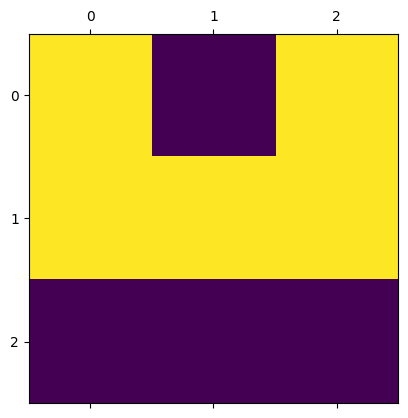

In [62]:
myMag = CreateMagnet(3)
print(myMag)
T = 1/0.3
nums = []
for i in range(10000):
    sweep(myMag, T)
    nums.append(ConvertToNumber(myMag))
DisplayMagnet(myMag)
print(myMag)
print(MeasureM2(myMag))

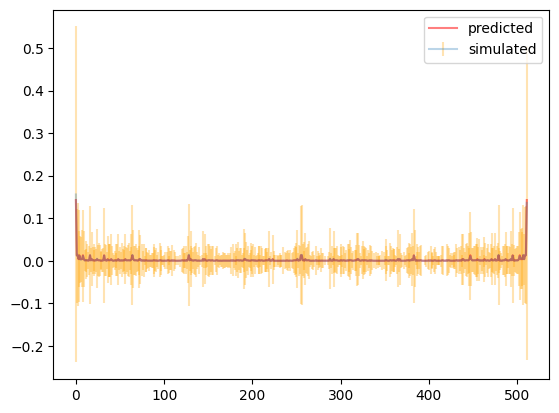

In [63]:
fig, ax = plt.subplots()
h = np.histogram(nums, bins = 2**9, density=True)
x = np.arange(0, 2**9)
b = ax.errorbar(x, h[0], yerr=np.sqrt(h[0]), alpha = 0.3, ecolor="orange", label="simulated")
out = []
for i in range(2**9):
    binlen = 9
    bi = bin(i)[2:].zfill(binlen)
    close = np.array(list(bi), dtype=int)
    mag = (close.reshape(3, 3) * 2) - 1
    E = totalEnergy(mag)
    out.append(E)
    # print(E)
each = np.exp(-1 * np.array(out)/T)
each = each / sum(each)
# print(each)
ax.plot(x, each, alpha=0.5, label="predicted", color="red")
plt.legend()
plt.show()

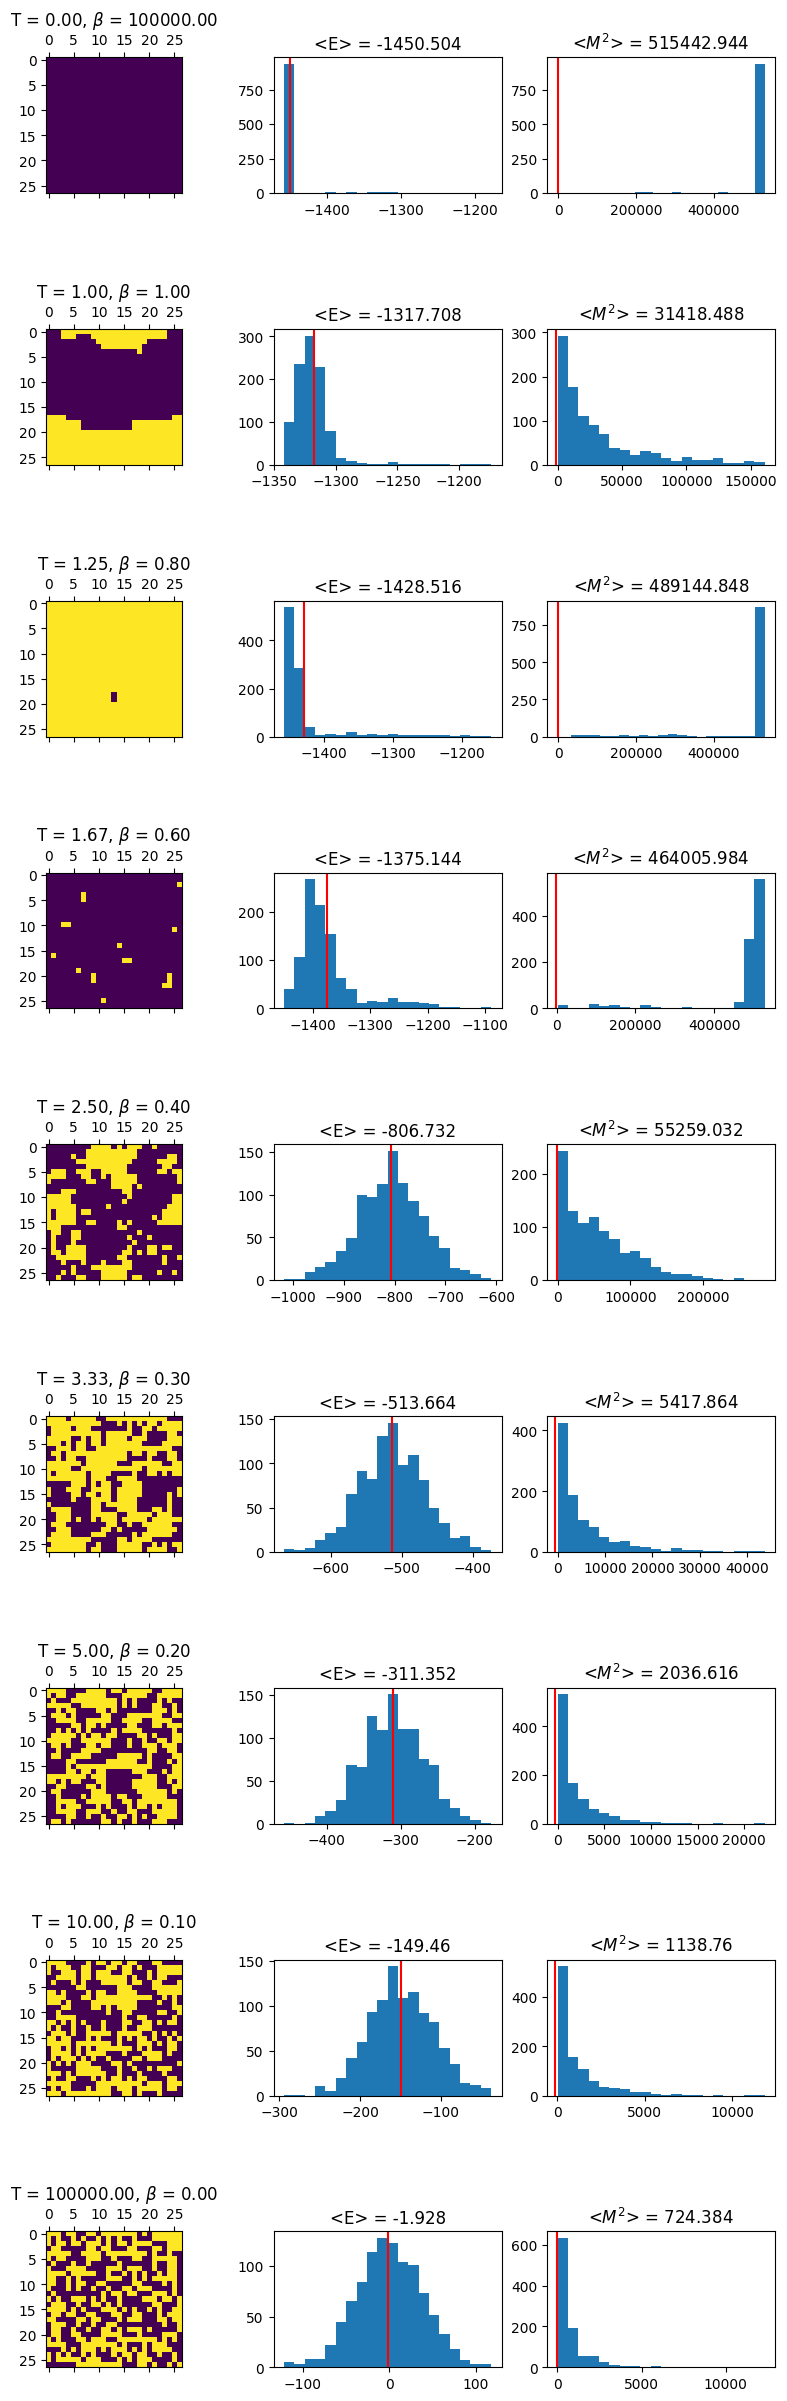

In [96]:

fig = plt.figure(figsize=(10, 30))
gs = fig.add_gridspec(9, 3, hspace=1)
axs = gs.subplots()
Ts = [0.00001, 1, 1/0.8, 1/0.6, 1/0.4, 1/0.3, 1/0.2, 1/0.1, 1/0.00001]
for j in range(9):
    Mag2 = CreateMagnet(27)
    store = MeasureThing(Mag2, [totalEnergy, MeasureM2], 1000, Ts[j])
    E = np.array([i[0] for i in store])
    M2 = np.array([i[1] for i in store])
    hE = np.histogram(E)
    hM2 = np.histogram(M2)
    axs[j, 0].matshow(Mag2)
    axs[j, 0].set_title(f"T = {Ts[j]:.2f}, " + r"$\beta$" + f" = {1/Ts[j]:.2f}")
    axs[j, 1].hist(E, bins = 20)
    axs[j, 1].axvline(E.mean(), color="red")
    axs[j, 1].set_title(f"<E> = {E.mean()}")
    axs[j, 2].hist(M2, bins = 20)
    axs[j, 2].axvline(E.mean(), color="red")
    axs[j, 2].set_title(r"<$M^2$>" + f" = {M2.mean()}")
    
x = np.arange(-100, 100, 200)
axs[8, 1].plot(x, np.exp(-x**2), color="green")

In [94]:
# targetTs = [1000000000, 1/0.3, 1/0.4, 1/0.5, 1/0.6, 0.0000001]
# for t in targetTs:
#     renormMag = CreateMagnet(81)
#     print(t)
#     RunForTime(renormMag, 1000, t)
#     DisplayMagnet(renormMag)
#     renormMag = Renormalize(renormMag, 3)
#     DisplayMagnet(renormMag)
#     renormMag = Renormalize(renormMag, 3)
#     DisplayMagnet(renormMag)

# print(renormMag)
# print(Renormalize(renormMag, 3))
# ConvertToNumber(renormMag)

In [93]:
uhoh = rng.choice([-1, 1], (27, 27))

totalEnergy(uhoh)

-38

In [ ]:
print(list("hello"))

['h', 'e', 'l', 'l', 'o']
